In [6]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

In [7]:
PROJECT_ROOT = Path(r"C:\Users\TUF\COMP0220_Deep_Learning\coursework")
RUNS_DIR = PROJECT_ROOT / "runs"

print("RUNS_DIR:", RUNS_DIR)
print("Exists:", RUNS_DIR.exists())

# List available runs
if RUNS_DIR.exists():
    for p in sorted(RUNS_DIR.glob("*")):
        if p.is_dir():
            print(" -", p.name)


RUNS_DIR: C:\Users\TUF\COMP0220_Deep_Learning\coursework\runs
Exists: True
 - cvs
 - cvs_baseline
 - detector
 - detector_baseline


In [8]:
def load_history(run_dir: Path) -> pd.DataFrame:
    hist = run_dir / "history.jsonl"
    if not hist.exists():
        raise FileNotFoundError(f"Missing {hist}")
    rows = []
    with hist.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    df = pd.DataFrame(rows)
    if "epoch" in df.columns:
        df = df.sort_values("epoch").reset_index(drop=True)
    return df

def load_meta(run_dir: Path) -> dict:
    meta = run_dir / "meta.json"
    if not meta.exists():
        return {}
    return json.loads(meta.read_text(encoding="utf-8"))

def moving_average(x, w=3):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="same")

def best_epoch(df: pd.DataFrame, metric: str, mode="max"):
    if metric not in df.columns:
        return None
    if mode == "max":
        i = df[metric].astype(float).idxmax()
    else:
        i = df[metric].astype(float).idxmin()
    return int(df.loc[i, "epoch"]), float(df.loc[i, metric])

Detector run: C:\Users\TUF\COMP0220_Deep_Learning\coursework\runs\detector_baseline exists: True
CVS run     : C:\Users\TUF\COMP0220_Deep_Learning\coursework\runs\cvs_baseline exists: True


,epoch,train_loss,val_map
0,1,0.723920,0.215877
1,2,0.589488,0.246215
2,3,0.540677,0.258061
3,4,0.499787,0.274077
4,5,0.475934,0.262652


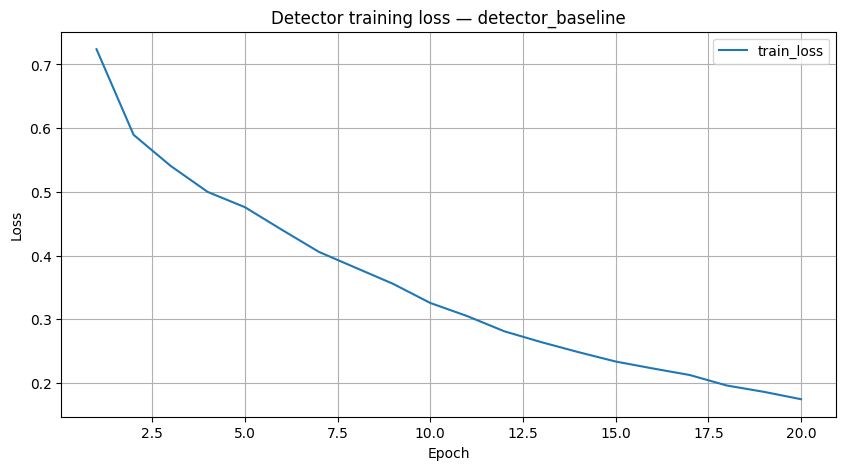

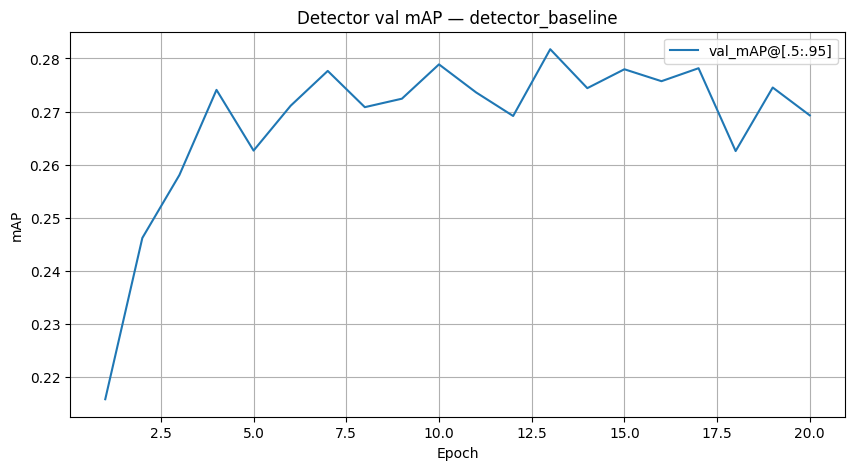

Best val_map: (13, 0.281724839566743)  (epoch, value)
Detector meta keys: ['config_path', 'data_root', 'train_split', 'val_split', 'ann_name', 'out_dir', 'epochs', 'batch_size', 'num_workers', 'lr', 'weight_decay', 'momentum', 'amp', 'img_min_size', 'img_max_size']


In [9]:
DETECTOR_RUN = RUNS_DIR / "detector_baseline"
CVS_RUN      = RUNS_DIR / "cvs_baseline"

print("Detector run:", DETECTOR_RUN, "exists:", DETECTOR_RUN.exists())
print("CVS run     :", CVS_RUN, "exists:", CVS_RUN.exists())


# =========================
# Cell 5 — Plot Detector curves (train_loss + val_map)
# =========================
det_df = load_history(DETECTOR_RUN)
det_meta = load_meta(DETECTOR_RUN)

display(det_df.head())

fig, ax = plt.subplots()
ax.plot(det_df["epoch"], det_df["train_loss"], label="train_loss")
ax.set_title(f"Detector training loss — {DETECTOR_RUN.name}")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True)
ax.legend()
plt.show()

if "val_map" in det_df.columns:
    fig, ax = plt.subplots()
    ax.plot(det_df["epoch"], det_df["val_map"], label="val_mAP@[.5:.95]")
    ax.set_title(f"Detector val mAP — {DETECTOR_RUN.name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("mAP")
    ax.grid(True)
    ax.legend()
    plt.show()

    be = best_epoch(det_df, "val_map", mode="max")
    print("Best val_map:", be, " (epoch, value)")

print("Detector meta keys:", list(det_meta.keys())[:15])

,epoch,train_loss,val_loss,val_macro_f1,per_criterion
0,1,0.949241,1.140720,0.433761,"[{'precision': 0.3682758620684576, 'recall': 0..."
1,2,0.731870,1.181413,0.408500,"[{'precision': 0.43678160919456555, 'recall': ..."
2,3,0.632254,1.022781,0.457803,"[{'precision': 0.435483870966864, 'recall': 0...."
3,4,0.563476,1.303951,0.398401,"[{'precision': 0.5794392523337409, 'recall': 0..."
4,5,0.519848,1.363833,0.462942,"[{'precision': 0.4928774928760887, 'recall': 0..."


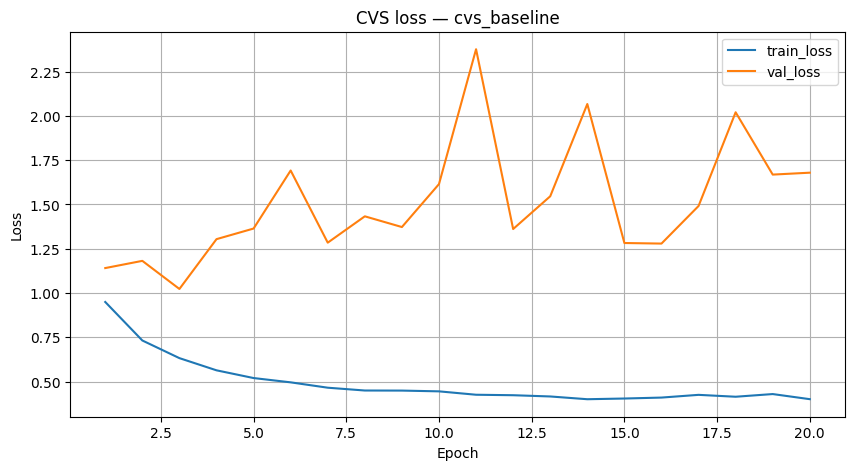

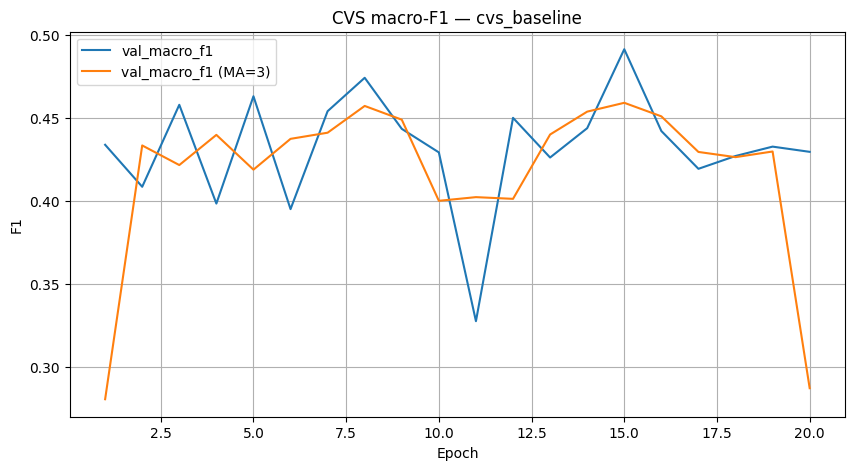

Best val_macro_f1: (15, 0.49122141770709)  (epoch, value)
CVS meta keys: ['config_path', 'data_root', 'metadata_csv', 'train_split', 'val_split', 'out_dir', 'epochs', 'batch_size', 'num_workers', 'lr', 'weight_decay', 'amp', 'freeze_backbone', 'seed', 'image_size']


In [10]:
cvs_df = load_history(CVS_RUN)
cvs_meta = load_meta(CVS_RUN)

display(cvs_df.head())

# Basic losses
fig, ax = plt.subplots()
ax.plot(cvs_df["epoch"], cvs_df["train_loss"], label="train_loss")
ax.plot(cvs_df["epoch"], cvs_df["val_loss"], label="val_loss")
ax.set_title(f"CVS loss — {CVS_RUN.name}")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True)
ax.legend()
plt.show()

# Macro F1
if "val_macro_f1" in cvs_df.columns:
    fig, ax = plt.subplots()
    ax.plot(cvs_df["epoch"], cvs_df["val_macro_f1"], label="val_macro_f1")
    ax.plot(cvs_df["epoch"], moving_average(cvs_df["val_macro_f1"], 3), label="val_macro_f1 (MA=3)")
    ax.set_title(f"CVS macro-F1 — {CVS_RUN.name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1")
    ax.grid(True)
    ax.legend()
    plt.show()

    be = best_epoch(cvs_df, "val_macro_f1", mode="max")
    print("Best val_macro_f1:", be, " (epoch, value)")

print("CVS meta keys:", list(cvs_meta.keys())[:15])


,epoch,criterion,precision,recall,f1,tp,fp,fn
0,1,C1,0.368276,0.700787,0.482821,267,458,114
1,1,C2,0.274791,0.790378,0.407801,230,607,61
2,1,C3,0.333333,0.534704,0.410661,208,416,181
3,2,C1,0.436782,0.598425,0.504983,228,294,153
4,2,C2,0.388112,0.381443,0.384749,111,175,180


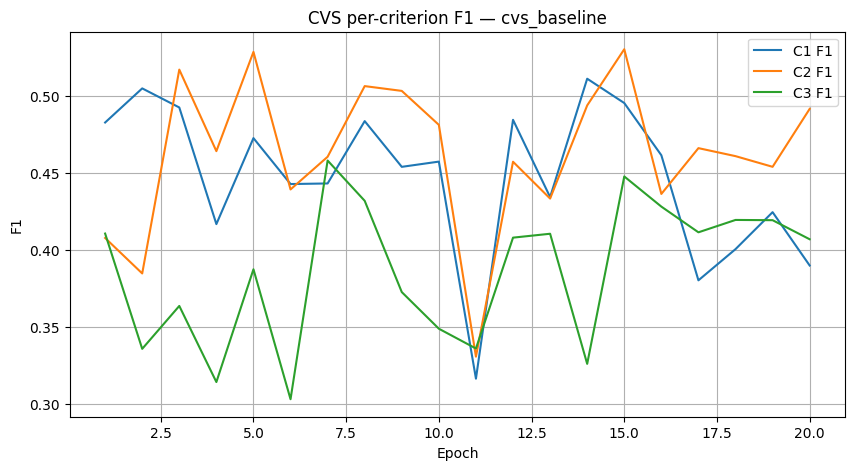

In [11]:
def explode_per_criterion(df: pd.DataFrame) -> pd.DataFrame:
    if "per_criterion" not in df.columns:
        raise RuntimeError("No per_criterion column found.")
    out = []
    for _, row in df.iterrows():
        epoch = int(row["epoch"])
        pc = row["per_criterion"]
        # robust: handle stringified JSON
        if isinstance(pc, str):
            pc = json.loads(pc)
        for i, name in enumerate(["C1", "C2", "C3"]):
            d = pc[i]
            out.append({
                "epoch": epoch,
                "criterion": name,
                "precision": float(d.get("precision", np.nan)),
                "recall": float(d.get("recall", np.nan)),
                "f1": float(d.get("f1", np.nan)),
                "tp": int(d.get("tp", 0)),
                "fp": int(d.get("fp", 0)),
                "fn": int(d.get("fn", 0)),
            })
    return pd.DataFrame(out)

pc_df = explode_per_criterion(cvs_df)
display(pc_df.head())

fig, ax = plt.subplots()
for name in ["C1", "C2", "C3"]:
    sub = pc_df[pc_df["criterion"] == name]
    ax.plot(sub["epoch"], sub["f1"], label=f"{name} F1")
ax.set_title(f"CVS per-criterion F1 — {CVS_RUN.name}")
ax.set_xlabel("Epoch")
ax.set_ylabel("F1")
ax.grid(True)
ax.legend()
plt.show()

,run,best_epoch,best_val_macro_f1,epochs_logged
0,cvs_baseline,15,0.491221,20


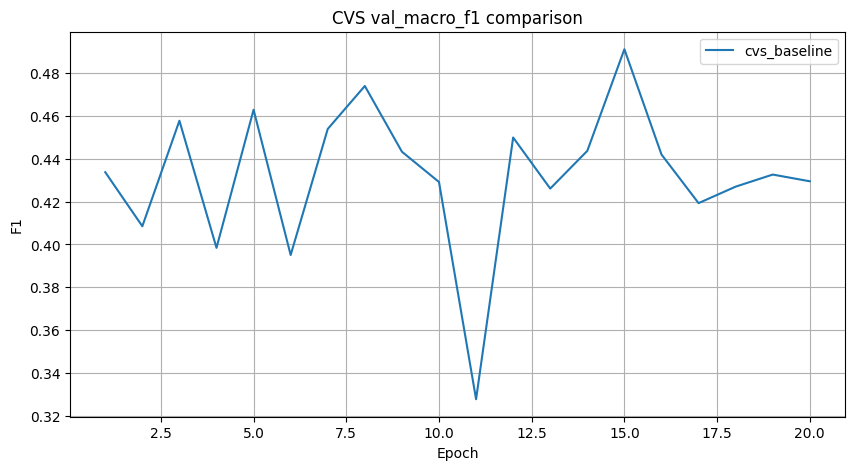

In [12]:
COMPARE_CVS_RUNS = ["cvs_baseline"]

rows = []
for rn in COMPARE_CVS_RUNS:
    rd = RUNS_DIR / rn
    if not rd.exists():
        print("Missing:", rd)
        continue
    df = load_history(rd)
    be = best_epoch(df, "val_macro_f1", mode="max")
    rows.append({"run": rn, "best_epoch": be[0] if be else None, "best_val_macro_f1": be[1] if be else None, "epochs_logged": len(df)})

comp = pd.DataFrame(rows).sort_values("best_val_macro_f1", ascending=False)
display(comp)

# Plot comparison curve
fig, ax = plt.subplots()
for rn in COMPARE_CVS_RUNS:
    rd = RUNS_DIR / rn
    if not rd.exists():
        continue
    df = load_history(rd)
    if "val_macro_f1" not in df.columns:
        continue
    ax.plot(df["epoch"], df["val_macro_f1"], label=rn)
ax.set_title("CVS val_macro_f1 comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("F1")
ax.grid(True)
ax.legend()
plt.show()